In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.3, 0.1, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 360/360 [00:18<00:00, 19.69it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6560755,
 'train_acc': 0.5244444608688354,
 'val_acc': 0.4466666281223297,
 'epoch': 30,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_30',
 'train_rmse': 0.9428090415820634,
 'val_rmse': 0.993310961716756,
 'test_rmse': 0.9927515074556953,
 'train_rmse_perc': 0.23002249,
 'val_rmse_perc': 0.23827523,
 'test_rmse_perc': 0.23585929,
 'train_mcc': 0.37624911385300813,
 'val_mcc': 0.2925307989793101,
 'test_mcc': 0.3580610431707958,
 'test_acc': 0.5055555701255798,
 'train_mae_perc': 0.17989895,
 'val_mae_perc': 0.19712794,
 'test_mae_perc': 0.18523756}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.61754525,
 'train_acc': 0.5155555605888367,
 'val_acc': 0.5199999213218689,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_50',
 'train_rmse': 0.855050355892044,
 'val_rmse': 0.8563488385776752,
 'test_rmse': 0.8647414514048565,
 'train_rmse_perc': 0.19767837,
 'val_rmse_perc': 0.20361818,
 'test_rmse_perc': 0.20520058,
 'train_mcc': 0.36082739845666156,
 'val_mcc': 0.3684139500703843,
 'test_mcc': 0.32500427676429866,
 'test_acc': 0.49000000953674316,
 'train_mae_perc': 0.15846884,
 'val_mae_perc': 0.16762327,
 'test_mae_perc': 0.16473559}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.61754525,
 'train_acc': 0.5155555605888367,
 'val_acc': 0.5199999213218689,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_50',
 'train_rmse': 0.855050355892044,
 'val_rmse': 0.8563488385776752,
 'test_rmse': 0.8647414514048565,
 'train_rmse_perc': 0.19767837,
 'val_rmse_perc': 0.20361818,
 'test_rmse_perc': 0.20520058,
 'train_mcc': 0.36082739845666156,
 'val_mcc': 0.3684139500703843,
 'test_mcc': 0.32500427676429866,
 'test_acc': 0.49000000953674316,
 'train_mae_perc': 0.15846884,
 'val_mae_perc': 0.16762327,
 'test_mae_perc': 0.16473559}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 360/360 [00:00<00:00, 21234.29it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

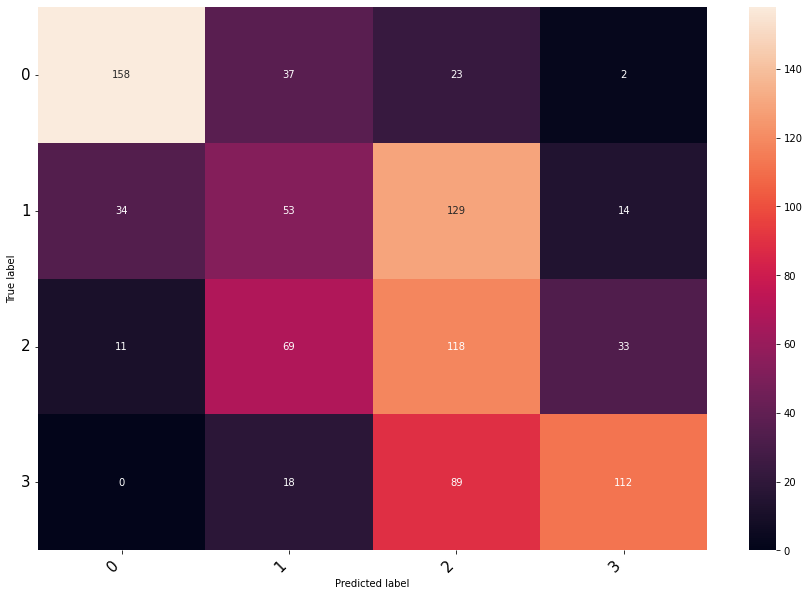

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.7182, 0.2304, 0.5108, 0.5114])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.18262328, 0.2398789, 0.18124937, 0.21084718]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.1270403, 0.21159242, 0.14348269, 0.17581004]

### GCN

In [20]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [22]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [00:44<00:00, 17.76it/s]


In [23]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.8592033,
 'train_acc': 0.46888887882232666,
 'val_acc': 0.4399999678134918,
 'epoch': 40,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_40',
 'train_rmse': 0.9614803401237304,
 'val_rmse': 1.0132456102380443,
 'test_rmse': 0.9480975102218594,
 'train_rmse_perc': 0.24854372,
 'val_rmse_perc': 0.27818856,
 'test_rmse_perc': 0.25209934,
 'train_mcc': 0.3570794540963187,
 'val_mcc': 0.32102556843335417,
 'test_mcc': 0.32181411051375597,
 'test_acc': 0.448888897895813,
 'train_mae_perc': 0.18571298,
 'val_mae_perc': 0.2079142,
 'test_mae_perc': 0.18825108}

In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7070204,
 'train_acc': 0.4355555474758148,
 'val_acc': 0.42666661739349365,
 'epoch': 40,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_40',
 'train_rmse': 0.8589399151150083,
 'val_rmse': 0.8906926143924925,
 'test_rmse': 0.848528137423857,
 'train_rmse_perc': 0.21126497,
 'val_rmse_perc': 0.21986537,
 'test_rmse_perc': 0.20699388,
 'train_mcc': 0.31572748158978436,
 'val_mcc': 0.3294969233157442,
 'test_mcc': 0.31213015874610706,
 'test_acc': 0.43666666746139526,
 'train_mae_perc': 0.17530748,
 'val_mae_perc': 0.19045606,
 'test_mae_perc': 0.17316501}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.70757496,
 'train_acc': 0.42888888716697693,
 'val_acc': 0.40666663646698,
 'epoch': 100,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_None_0.2_0.1_adamw_max_val_mcc_True_mse_True_0_100',
 'train_rmse': 0.896908269804914,
 'val_rmse': 0.8679477710861024,
 'test_rmse': 0.8993825042154694,
 'train_rmse_perc': 0.218162,
 'val_rmse_perc': 0.21597277,
 'test_rmse_perc': 0.21543163,
 'train_mcc': 0.32430018154737233,
 'val_mcc': 0.3217840919983867,
 'test_mcc': 0.31808145652748615,
 'test_acc': 0.42444443702697754,
 'train_mae_perc': 0.18222663,
 'val_mae_perc': 0.18916611,
 'test_mae_perc': 0.17980808}

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 20362.32it/s]


### GraphSAGE

In [27]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [29]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [05:42<00:00,  3.47it/s]


True

In [30]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22097655,
 'train_acc': 0.8755555748939514,
 'val_acc': 0.7866665720939636,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_100',
 'train_rmse': 0.3620926830400072,
 'val_rmse': 0.46188021535170065,
 'test_rmse': 0.5077182070575939,
 'train_rmse_perc': 0.0955169,
 'val_rmse_perc': 0.097058006,
 'test_rmse_perc': 0.11293285,
 'train_mcc': 0.8406196646974875,
 'val_mcc': 0.724312043858121,
 'test_mcc': 0.7191390967884483,
 'test_acc': 0.7811111211776733,
 'train_mae_perc': 0.0

In [31]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.15963303,
 'train_acc': 0.8711110949516296,
 'val_acc': 0.7933332324028015,
 'epoch': 90,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_90',
 'train_rmse': 0.3681787005729087,
 'val_rmse': 0.4546060565661952,
 'test_rmse': 0.5120763831912406,
 'train_rmse_perc': 0.09565475,
 'val_rmse_perc': 0.0973733,
 'test_rmse_perc': 0.112529375,
 'train_mcc': 0.8350890516871152,
 'val_mcc': 0.7333719019474649,
 'test_mcc': 0.7127038053386103,
 'test_acc': 0.7766666412353516,
 'train_mae_perc': 0.075

In [32]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.073610105,
 'train_acc': 0.8911111354827881,
 'val_acc': 0.8199999332427979,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_100',
 'train_rmse': 0.339934634239519,
 'val_rmse': 0.4472135954999579,
 'test_rmse': 0.5507570547286103,
 'train_rmse_perc': 0.092021026,
 'val_rmse_perc': 0.09583467,
 'test_rmse_perc': 0.11827958,
 'train_mcc': 0.8595663333485564,
 'val_mcc': 0.7720506106789574,
 'test_mcc': 0.6881445895928842,
 'test_acc': 0.7566666603088379,
 'train_mae_perc': 0.0715

In [33]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 23343.72it/s]


#### cm

In [34]:
cm = all[sort_idx[0]]['test_cm'][0]

In [35]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

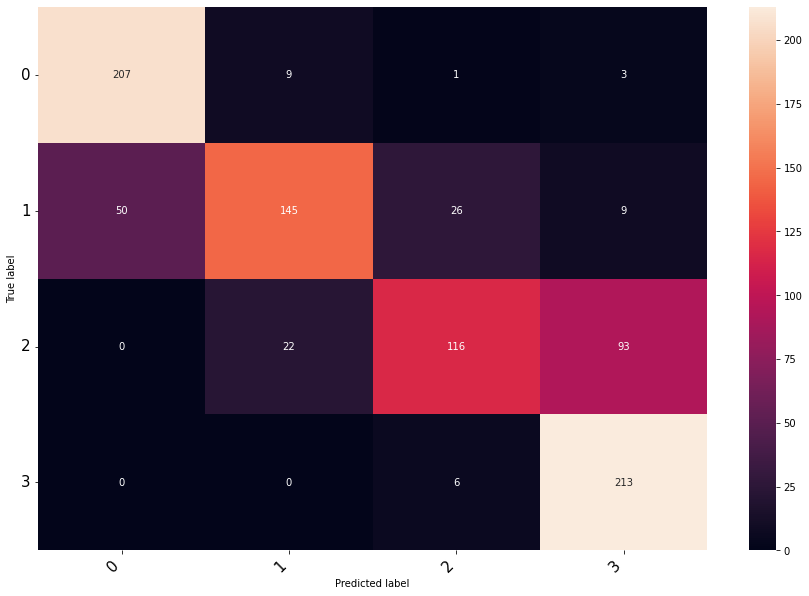

In [36]:
cm.visualize()

In [37]:
cm.class_accuracy

tensor([0.9409, 0.6304, 0.5022, 0.9726])

In [38]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.116458245, 0.13468535, 0.1340622, 0.07655173]

In [39]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08108264, 0.093518, 0.10351706, 0.060727593]

#### GraphSAGE Base_n

In [40]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [41]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

##### Results

In [42]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [05:20<00:00,  3.70it/s]


True

In [43]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04951141,
 'train_acc': 0.7644444704055786,
 'val_acc': 0.7266665697097778,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.48534065928536785,
 'val_rmse': 0.5228129047119374,
 'test_rmse': 0.5617433182117573,
 'train_rmse_perc': 0.10535672,
 'val_rmse_perc': 0.113051005,
 'test_rmse_perc': 0.11916154,
 'train_mcc': 0.7073445206783293,
 'val_mcc': 0.6460370623263033,
 'test_mcc': 0.6135246676281126,
 'test_acc': 0.6977777481079102,
 'train_mae_perc': 0.08424

In [44]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04951141,
 'train_acc': 0.7644444704055786,
 'val_acc': 0.7266665697097778,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.48534065928536785,
 'val_rmse': 0.5228129047119374,
 'test_rmse': 0.5617433182117573,
 'train_rmse_perc': 0.10535672,
 'val_rmse_perc': 0.113051005,
 'test_rmse_perc': 0.11916154,
 'train_mcc': 0.7073445206783293,
 'val_mcc': 0.6460370623263033,
 'test_mcc': 0.6135246676281126,
 'test_acc': 0.6977777481079102,
 'train_mae_perc': 0.08424

In [45]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04951141,
 'train_acc': 0.7644444704055786,
 'val_acc': 0.7266665697097778,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.48534065928536785,
 'val_rmse': 0.5228129047119374,
 'test_rmse': 0.5617433182117573,
 'train_rmse_perc': 0.10535672,
 'val_rmse_perc': 0.113051005,
 'test_rmse_perc': 0.11916154,
 'train_mcc': 0.7073445206783293,
 'val_mcc': 0.6460370623263033,
 'test_mcc': 0.6135246676281126,
 'test_acc': 0.6977777481079102,
 'train_mae_perc': 0.08424

In [46]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 15078.34it/s]


##### cm

In [47]:
cm = all[sort_idx[0]]['test_cm'][0]

In [48]:
(cm.labels==0).sum()

tensor(220)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

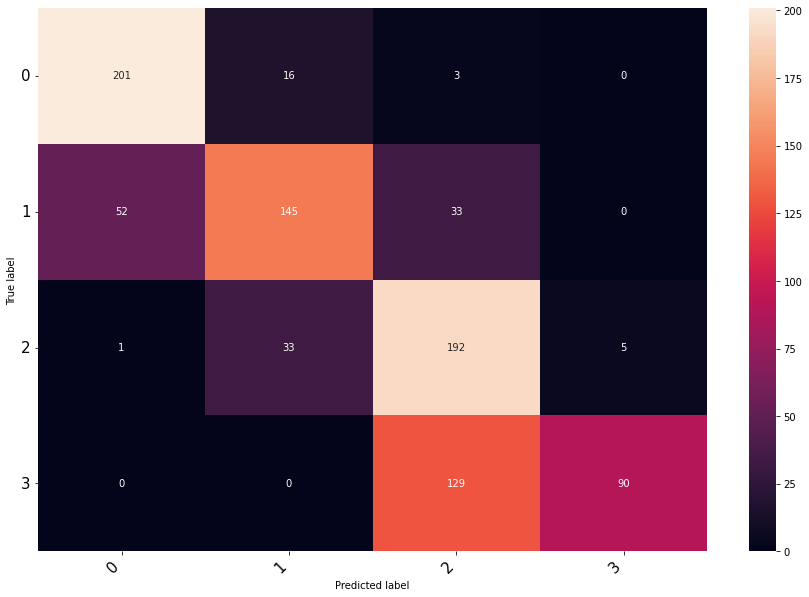

In [49]:
cm.visualize()

In [50]:
cm.class_accuracy

tensor([0.9136, 0.6304, 0.8312, 0.4110])

In [51]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10219166, 0.10870942, 0.0905942, 0.16369127]

In [52]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08001196, 0.08714024, 0.06121609, 0.14388841]

### GAT

In [53]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [55]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [02:42<00:00, 19.44it/s]


In [56]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.70084965,
 'train_acc': 0.5888888835906982,
 'val_acc': 0.5466666221618652,
 'epoch': 80,
 'model_class': 'gat',
 'path_name': '4_[15]_1_[2_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_80',
 'train_rmse': 0.7586537784494028,
 'val_rmse': 0.9237604307034013,
 'test_rmse': 0.7852812659593165,
 'train_rmse_perc': 0.17334342,
 'val_rmse_perc': 0.22473057,
 'test_rmse_perc': 0.18326372,
 'train_mcc': 0.4519725404988363,
 'val_mcc': 0.3967701187445068,
 'test_mcc': 0.45337572044835295,
 'test_acc': 0.58999997

In [57]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.79164374,
 'train_acc': 0.6333333253860474,
 'val_acc': 0.5666666030883789,
 'epoch': 90,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[2_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_90',
 'train_rmse': 0.7071067811865476,
 'val_rmse': 0.8366600265340756,
 'test_rmse': 0.7673909622147559,
 'train_rmse_perc': 0.15956657,
 'val_rmse_perc': 0.20582612,
 'test_rmse_perc': 0.17336796,
 'train_mcc': 0.5181220804382115,
 'val_mcc': 0.4321666189510367,
 'test_mcc': 0.44463026127451555,
 'test_acc': 0.57999998

In [58]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6118202,
 'train_acc': 0.6222222447395325,
 'val_acc': 0.5533332824707031,
 'epoch': 80,
 'model_class': 'gat',
 'path_name': '4_[25_25]_1_[4_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_80',
 'train_rmse': 0.7055336829505575,
 'val_rmse': 0.8445906306213286,
 'test_rmse': 0.8103497187428812,
 'train_rmse_perc': 0.16508865,
 'val_rmse_perc': 0.19542648,
 'test_rmse_perc': 0.18012221,
 'train_mcc': 0.49711088927351227,
 'val_mcc': 0.4062612413926131,
 'test_mcc': 0.40248939113283116,
 'test_acc': 0.55111

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 18792.71it/s]
